In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [26]:
def unet_model(input_size=(128, 128, 3)):
    inputs = tf.keras.Input(input_size)
    
    # Encoding layers
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoding layers
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [27]:
def preprocess_images(image_paths, mask_paths, image_size=(128, 128)):
    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load image and resize
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        images.append(img)

        # Load mask and resize
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, image_size)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        masks.append(mask)

    images = np.array(images) / 255.0  # Normalize images
    masks = np.array(masks) / 255.0    # Normalize masks
    
    return images, masks




In [66]:
import os
def get_image_paths(folder_path):
    image_paths =[]
    
    for root,dirs,files in os.walk(folder_path):
        count = 0
        for file in files:
            if count > 40:
                break
            else: 
                image_paths.append(os.path.join(root,file))
                count +=1

    return image_paths


In [67]:
# Example usage:
image_paths = get_image_paths(r"C:\Users\SIDDHARTH\Downloads\CASIA2\Tp")
mask_paths = get_image_paths(r"C:\Users\SIDDHARTH\Downloads\CASIA2\CASIA 2 Groundtruth")   
images, masks = preprocess_images(image_paths, mask_paths)

In [68]:
print(image_paths)
print(mask_paths)

['C:\\Users\\SIDDHARTH\\Downloads\\CASIA2\\Tp\\Tp_D_CND_M_N_ani00018_sec00096_00138.tif', 'C:\\Users\\SIDDHARTH\\Downloads\\CASIA2\\Tp\\Tp_D_CND_M_N_art00076_art00077_10289.tif', 'C:\\Users\\SIDDHARTH\\Downloads\\CASIA2\\Tp\\Tp_D_CND_M_N_art00077_art00076_10290.tif', 'C:\\Users\\SIDDHARTH\\Downloads\\CASIA2\\Tp\\Tp_D_CND_S_N_ani00073_ani00068_00193.tif', 'C:\\Users\\SIDDHARTH\\Downloads\\CASIA2\\Tp\\Tp_D_CND_S_N_ind00078_ind00077_00476.tif', 'C:\\Users\\SIDDHARTH\\Downloads\\CASIA2\\Tp\\Tp_D_CND_S_N_txt00028_txt00006_10848.jpg', 'C:\\Users\\SIDDHARTH\\Downloads\\CASIA2\\Tp\\Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg', 'C:\\Users\\SIDDHARTH\\Downloads\\CASIA2\\Tp\\Tp_D_CNN_M_B_nat10139_nat00059_11949.jpg', 'C:\\Users\\SIDDHARTH\\Downloads\\CASIA2\\Tp\\Tp_D_CNN_M_B_nat10139_nat00097_11948.jpg', 'C:\\Users\\SIDDHARTH\\Downloads\\CASIA2\\Tp\\Tp_D_CNN_M_N_ani00023_ani00024_10205.tif', 'C:\\Users\\SIDDHARTH\\Downloads\\CASIA2\\Tp\\Tp_D_CNN_M_N_ani00052_ani00054_11130.jpg', 'C:\\Users\\SIDDHART

In [76]:
# Split dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
# Initialize the model
model = unet_model()

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=16)


In [45]:
def prediction(model, image_path, threshold = 0.5):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (128,128))/255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    pred_mask = model.predict(img_resized)
    pred_mask = (pred_mask > threshold).astype(np.uint8)

    return pred_mask



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


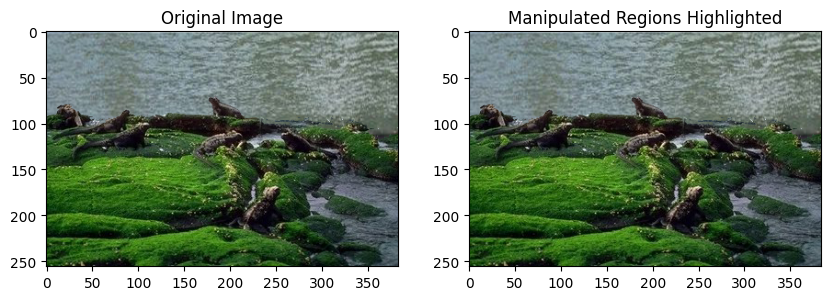

In [62]:
def highlight_forged_areas(model, image_paths, threshold=0.5):
    img = cv2.imread(image_paths)
    img_resized = cv2.resize(img, (128, 128)) / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension

    # Predict mask
    pred_mask = model.predict(img_resized)
    pred_mask = (pred_mask > threshold).astype(np.uint8)  # Threshold to create binary mask
    
    # Resize mask to original image size
    mask_resized = cv2.resize(pred_mask[0], (img.shape[1], img.shape[0]))

    # Highlight the manipulated regions
    highlighted_image = img.copy()
    highlighted_image[mask_resized > 0] = [0, 0, 255]  # Color the manipulated regions in red

    # Show the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 2, 2)
    plt.title('Manipulated Regions Highlighted')
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    plt.show()

# Example usage
highlight_forged_areas(model, r"C:\Users\SIDDHARTH\Downloads\CASIA2\Tp\Tp_D_CND_M_N_ani00018_sec00096_00138.tif")
